# Used Python libraries

* Numpy for numerics
* Matplotlib for plotting
* Scipy for regression
* ChaosPy for Polynomial Chaos

In [7]:
import numpy as np
from numpy import sqrt, sin, cos, tan, sinh, cosh, tanh, exp, pi
import matplotlib.pyplot as plt
import scipy as sp
import chaospy as cp

# 1. Take experimental plasma profiles
For testing, we invent an artificial temperature profile $T(r)$ over radial variable $r$.

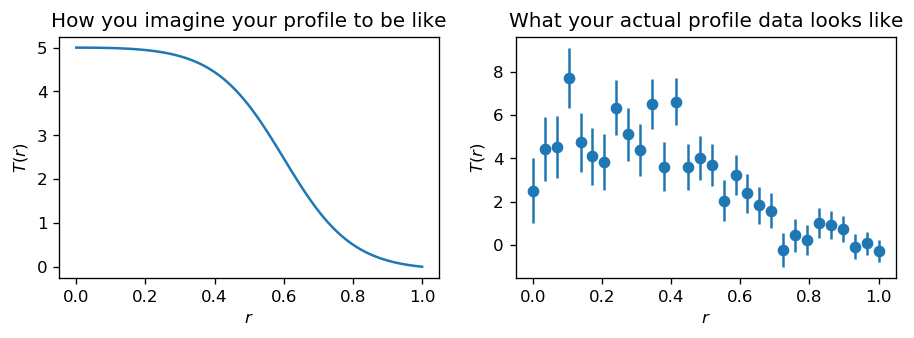

In [107]:
def tprof(r, u, v):
    w = 5.0 # fixed parameter for the pedestal width
    # tanh shape, second term such that dT/dr=0 at r=0
    Tnorm = tanh(w * (v - r)) + r * w / cosh(w * v)**2 
    # values at r=0, r=1 for normalization
    Tnorm0 = tanh(w * v) 
    Tnorm1 = tanh(w * (v - 1)) + w / cosh(w * v)**2
    # return normalized result scaled with u = T(r=0)
    return u/(Tnorm0 - Tnorm1)*(Tnorm - Tnorm1)

r = np.linspace(0.0, 1.0, 100)

u0 = 5
v0 = 0.6

rexp = np.linspace(0.0, 1.0, 30)

Texp0 = tprof(rexp, 5, 0.6)
dTexp = 1.5 - rexp
Texp = np.random.normal(Texp0, dTexp)

plt.figure(dpi=120, figsize=(9,2.66))

plt.subplot(1,2,1)
plt.plot(r, tprof(r, u0, v0))
plt.xlabel(r'$r$')
plt.ylabel(r'$T(r)$')
plt.title("How you imagine your profile to be like")

plt.subplot(1,2,2)
plt.errorbar(rexp, Texp, yerr=dTexp, fmt='o')
plt.xlabel(r'$r$')
plt.ylabel(r'$T(r)$')
plt.title("What your actual profile data looks like")

plt.show()

We would like to **propagate uncertainties** to **modeling results**.


# 2. Choose parametrization for profile
Here we use two free parameters
* $u = T(0)$ is the on-axis temperature
* $v$ parameterizes the pedestal radial position
```python
def tprof(r, u, v):
    w = 5.0 # fixed parameter for pedestal width
    Tnorm = tanh(w*(v - r)) + r*w/cosh(w*v)**2 # tanh-like
    Tnorm0 = tanh(w*v) # Tnorm at r=0
    Tnorm1 = tanh(w*(v - 1)) + w/cosh(w*v)**2 # Tnorm at r=1
    return u/(Tnorm0 - Tnorm1)*(Tnorm - Tnorm1) # scale with u
```
* Outboard temperature $T(1)$ must vanish
* Radial derivatives dT/dr must vanish on axis at $r=0$ (depends on choice of $r$)

# 3. Fit profile parameters
* Least-squares regression assumes (multivariate) Normal distribution for parameters $\rightarrow$ Gaussian probability density. Use this one for simplicity.
* Alternative: Bayesian regression to estimate actual distribution
* If too many and/or correlated parameters, reduce by PCA
* If non-Gaussian and correlated, use Rosenblatt transform

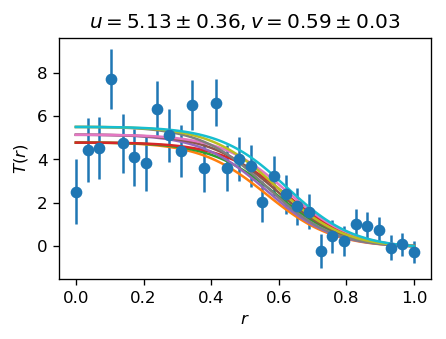

In [108]:
fit = sp.optimize.curve_fit(tprof, rexp, Texp, p0=[6, 0.5], sigma=dTexp)

u0 = fit[0][0]
du = sqrt(fit[1][0,0])
v0 = fit[0][1]
dv = sqrt(fit[1][1,1])

plt.figure(dpi=120, figsize=(4,2.66))
plt.errorbar(rexp, Texp, yerr=dTexp, fmt='o')
for uk in [u0 - du, u0, u0 + du]:
    for vk in [v0 - dv, v0, v0 + dv]:
        plt.plot(r, tprof(r, uk, vk))
plt.xlabel(r'$r$')
plt.ylabel(r'$T(r)$')

plt.title(r'$u = {:.2f} \pm {:.2f}, v = {:.2f} \pm {:.2f}$'.format(u0, du, v0, dv))
plt.show()

# 4. Run our model
Assume we have a model $f(r, T(r))$ that, for a given profile, yields a certain result,

$$ f(r, T(r; u,v)) \equiv f(r; u,v).$$

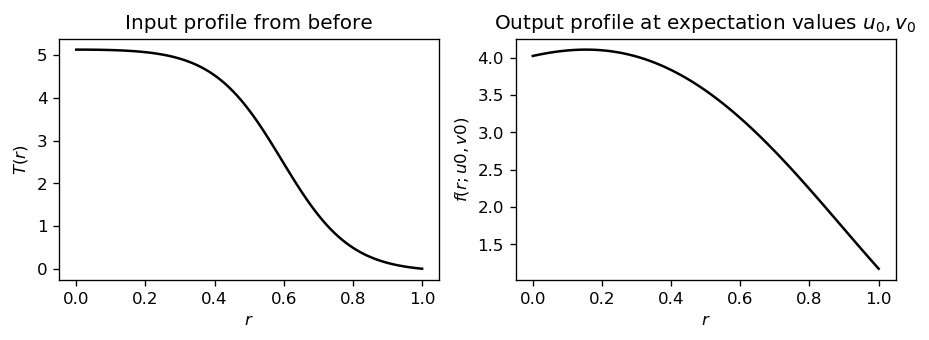

In [109]:
# define some model for testing via the rosenbrock function
# to introduce some non-trivial behavior in the u,v space.
def rosenbrock(x, y, a, b):
    return (a - x)**2 + b * (y - x**2)**2
def f(r, u, v):
    return rosenbrock((r - 0.5) + u - 5, 1 + 3 * (v - 0.6), a=1, b=3)

plt.figure(dpi=120, figsize=(9,2.66))

plt.subplot(1,2,1)
plt.plot(r, tprof(r, u0, v0), 'k')
plt.xlabel(r'$r$')
plt.ylabel(r'$T(r)$')
plt.title("Input profile from before")

plt.subplot(1,2,2)
plt.plot(r, f(r, u0, v0), 'k')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r; u0, v0)$')
plt.title("Output profile at expectation values $u_0,v_0$")

plt.show()

Usually, model is run at fitted $u_0,v_0$ and conclusions based on it are published.

# 5. Account for input uncertainty
High experimental uncertainties can lead us to doubt the reliability of our result. First try: Add error bars by running the model at standard deviation distance,
$$ f(r; u_0 + \Delta u, v_0), f(r; u_0 - \Delta u, v_0), f(r; u_0, v_0 - \Delta v), f(r; u_0, v_0 + \Delta v) $$

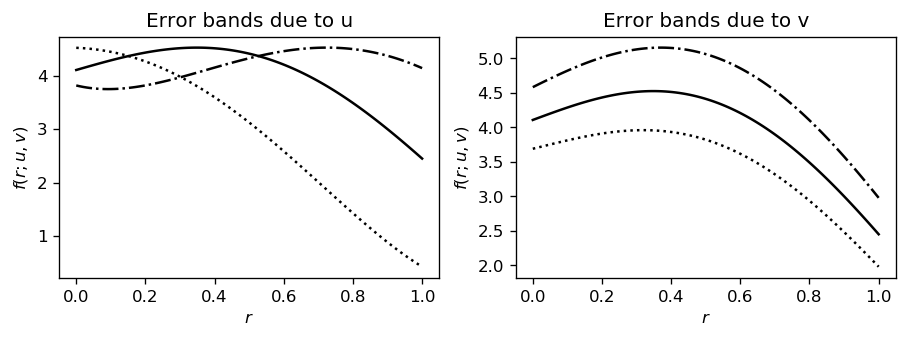

In [53]:
plt.figure(dpi=120, figsize=(9, 2.66))

plt.subplot(1,2,1)
plt.plot(r, f(r, u0, v0), 'k')
plt.plot(r, f(r, u0 - du, v0), 'k-.')
plt.plot(r, f(r, u0 + du, v0), 'k:')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r; u, v)$')
plt.title("Error bands due to u")

plt.subplot(1,2,2)
plt.plot(r, f(r, u0, v0), 'k')
plt.plot(r, f(r, u0 , v0 + dv), 'k-.')
plt.plot(r, f(r, u0 , v0 - dv), 'k:')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r; u, v)$')
plt.title("Error bands due to v")

plt.show()


There is quite some **uncertainty**, looks reasonable in $v$, but **not at all** in $u$.

Let's try again, but this time with 5 times smaller uncertainties in $u,v$.

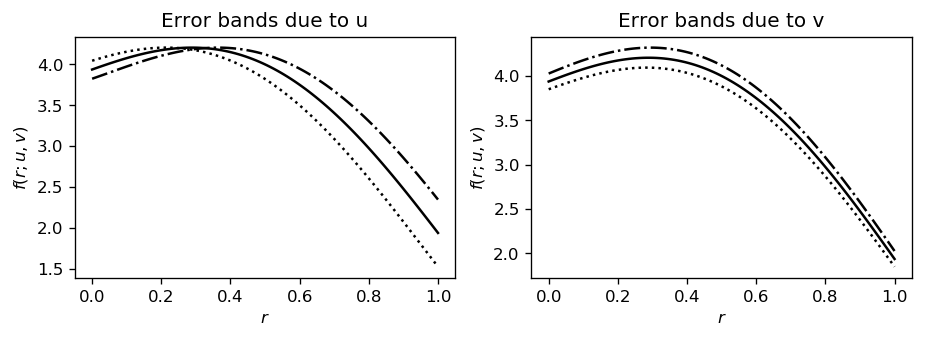

In [60]:
plt.figure(dpi=120, figsize=(9, 2.66))

plt.subplot(1,2,1)
plt.plot(r, f(r, u0, v0), 'k')
plt.plot(r, f(r, u0 - .2*du, v0), 'k-.')
plt.plot(r, f(r, u0 + .2*du, v0), 'k:')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r; u, v)$')
plt.title("Error bands due to u")

plt.subplot(1,2,2)
plt.plot(r, f(r, u0, v0), 'k')
plt.plot(r, f(r, u0 , v0 + .2*dv), 'k-.')
plt.plot(r, f(r, u0 , v0 - .2*dv), 'k:')
plt.xlabel(r'$r$')
plt.ylabel(r'$f(r; u, v)$')
plt.title("Error bands due to v")

plt.show()


Reducing input error to $2\%$ we see that error band due to $u$ **switches sign** at $r \approx 0.25$. It **fails** at $10\%$ input error because we have left the **linear range**. To investigate, look at **actual** dependency of $f$ on parameters $u,v$.

# What has gone wrong?
Of course I've maliciously designed $f$ such that it depends on $u,v$ in a **non-linear** way.

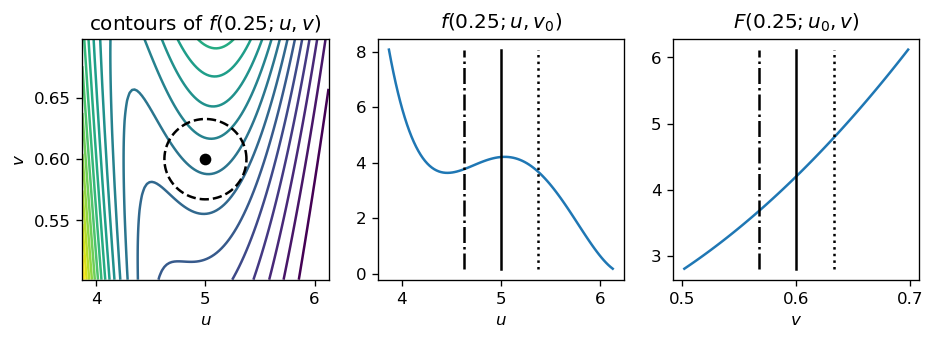

In [68]:
u = np.linspace(u0 - 3 * du, u0 + 3 * du, 100)
v = np.linspace(v0 - 3 * dv, v0 + 3 * dv, 100)
U, V = np.meshgrid(u, v)

F = f(0.25, U, V)
fu = f(0.25, u, v0)
fv = f(0.25, u0, v)

plt.figure(dpi=120, figsize=(9, 2.66))

plt.subplot(1,3,1)
plt.contour(U, V, F, 20)
plt.plot(u0, v0, 'ko')
ph = np.linspace(0, 2 * pi, 100)
rho = np.ones(np.size(ph))
plt.plot(u0 + du * rho * cos(ph), v0 + dv * rho * sin(ph), 'k--')
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.title(r'contours of $f(0.25; u, v)$')

plt.subplot(1,3,2)
plt.plot(u, fu)
plt.plot((u0, u0), (np.min(fu), np.max(fu)), 'k')
plt.plot((u0 - du, u0 - du), (np.min(fu), np.max(fu)), 'k-.')
plt.plot((u0 + du, u0 + du), (np.min(fu), np.max(fu)), 'k:')
plt.xlabel(r'$u$')
plt.title(r'$f(0.25; u, v_0)$')

plt.subplot(1,3,3)
plt.plot(v, fv)
plt.plot((v0, v0), (np.min(fv), np.max(fv)), 'k')
plt.plot((v0 - dv, v0 - dv), (np.min(fv), np.max(fv)), 'k-.')
plt.plot((v0 + dv, v0 + dv), (np.min(fv), np.max(fv)), 'k:')
plt.xlabel(r'$v$')
plt.title(r'$F(0.25; u_0, v)$')

plt.show()

 Here we hit a **local maximum** that explains switch in sign of error bands. There is no reason why it can't be **even worse** in practice.
Still $f$ depends on $u,v$ in a nice **continuous** way $\rightarrow$ can **expand** in **polynomials**.

# Expansion in polynomials

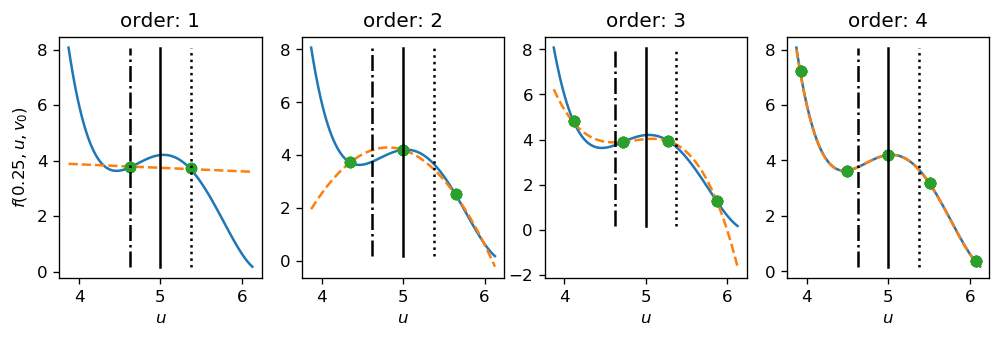

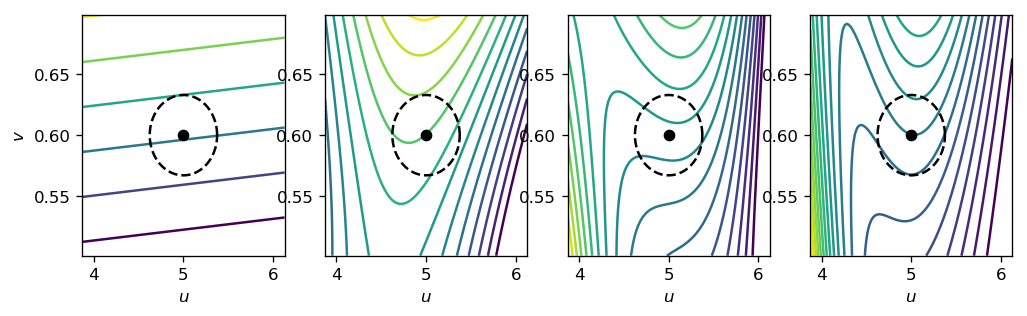

In [82]:
distribution = cp.J(
    cp.Normal(u0, du),
    cp.Normal(v0, dv)
)

plt.figure(dpi=120, figsize=(10,2.66))
for order in [1,2,3,4]:
    expansion = cp.orth_ttr(order, distribution)
    nodes, weights = cp.generate_quadrature(order, distribution, rule='G')
    sol = [f(r, node[0], node[1]) for node in nodes.T]
    approx = cp.fit_quadrature(expansion, nodes, weights, sol)
    plt.subplot(1,4,order)
    plt.plot(u, f(.25, u, v0))
    plt.plot(u, approx[25](u, v0), '--')
    plt.plot(nodes[0, :], approx[24](nodes[0, :], v0), 'o')
    plt.plot((u0, u0), (np.min(fu), np.max(fu)), 'k')
    plt.plot((u0 - du, u0 - du), (np.min(fu), np.max(fu)), 'k-.')
    plt.plot((u0 + du, u0 + du), (np.min(fu), np.max(fu)), 'k:')
    plt.xlabel(r'$u$')
    if order == 1:
        plt.ylabel(r'$f(0.25,u,v_0)$')
    plt.title('order: {}'.format(order))
    
plt.figure(dpi=120, figsize=(10,2.66))
for order in [1,2,3,4]:
    expansion = cp.orth_ttr(order, distribution)
    nodes, weights = cp.generate_quadrature(order, distribution, rule='G')
    sol = [f(r, node[0], node[1]) for node in nodes.T]
    approx = cp.fit_quadrature(expansion, nodes, weights, sol)
    plt.subplot(1,4,order)
    plt.contour(U, V, approx[25](U,V), np.linspace(0,10,20))
    plt.plot(u0, v0, 'ko')
    ph = np.linspace(0, 2 * pi, 100)
    rho = np.ones(np.size(ph))
    plt.plot(u0 + du * rho * cos(ph), v0 + dv * rho * sin(ph), 'k--')
    plt.xlabel(r'$u$')
    if order == 1:
        plt.ylabel(r'$v$')

# Polynomial Chaos Expansion

How do (moments of) distribution in parameters $(u,v)$ propagate to $f(r; u,v)$ ?

Polynomial chaos expansion uses analytical expressions when parameters $(u,v)$ are fed to polynomial approximations to $f$. 

There exists a variety of different polynomials suited for different distributions of parameters. Generally, **probability density function** $p(x)$ of parameters is equal to **weight function** under which polynomials are orthogonal. e.g. Hermite polynomials

$$ \int_{-\infty}^{\infty} H_m(x) H_n(x) e^{-x^2} du \propto \delta_{mn} $$

to be used with Normal distribution with Gaussian probability density function.

# Polynomial Chaos Expansion

Order: 1, number of model evaluations: 4
Order: 2, number of model evaluations: 9
Order: 3, number of model evaluations: 16
Order: 4, number of model evaluations: 25


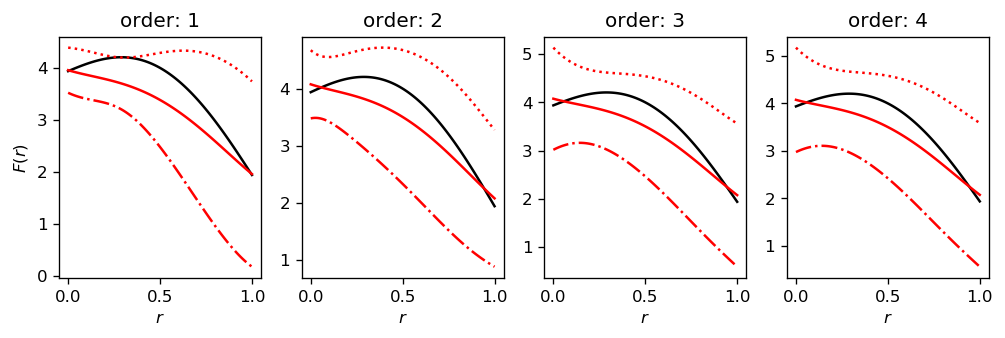

In [88]:
plt.figure(dpi=120, figsize=(10,2.66))
for order in [1,2,3,4]:
    expansion = cp.orth_ttr(order, distribution)
    nodes, weights = cp.generate_quadrature(order, distribution, rule='G')
    print('Order: {}, number of model evaluations: {}'.format(order, nodes.shape[1]))
    sol = [f(r, node[0], node[1]) for node in nodes.T]
    approx = cp.fit_quadrature(expansion, nodes, weights, sol)
    plt.subplot(1,4,order)
    F0 = cp.E(approx, distribution)
    dF = cp.Std(approx, distribution)

    plt.plot(r, f(r, u0, v0), 'k')
    plt.plot(r, F0, 'r')
    plt.plot(r, F0 + dF, 'r:')
    plt.plot(r, F0 - dF, 'r-.')
    plt.xlabel(r'$r$')
    if order == 1:
        plt.ylabel(r'$f(r)$')
    plt.title('order: {}'.format(order))

1. **Expectation value** of $f$ **different** from run at expectation values of $(u_0,v_0)$.
2. Here, expectation value accurate already in **1st order**, error bands at order $\geq$ 3.

# Polynomial Chaos Expansion

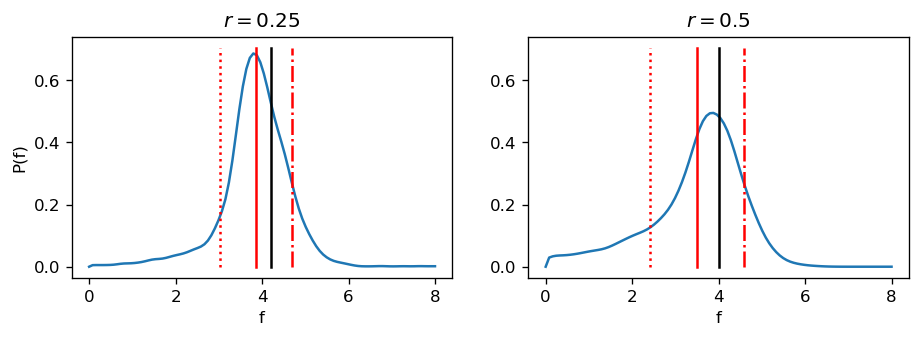

In [97]:
# %%
Fdist = cp.QoI_Dist(approx, distribution)
Ftest = np.linspace(0, 8, 100)

# %%
plt.figure(dpi=120, figsize=(9,2.66))

plt.subplot(1,2,1)
plt.plot(Ftest, Fdist[25].pdf(Ftest))
plt.plot((f(.25,u0,v0), f(.25,u0,v0)), (np.min(Fpdf), np.max(Fpdf)), 'k')
plt.plot((F0[25], F0[25]), (np.min(Fpdf), np.max(Fpdf)), 'r')
plt.plot((F0[25] + dF[25], F0[25] + dF[25]),
         (np.min(Fpdf), np.max(Fpdf)), 'r-.')
plt.plot((F0[25] - dF[25], F0[25] - dF[25]),
         (np.min(Fpdf), np.max(Fpdf)), 'r:')
plt.xlabel('f')
plt.ylabel('P(f)')
plt.title(r'$r=0.25$')

plt.subplot(1,2,2)
plt.plot(Ftest, Fdist[50].pdf(Ftest))
plt.plot((f(.5,u0,v0), f(.5,u0,v0)), (np.min(Fpdf), np.max(Fpdf)), 'k')
plt.plot((F0[50], F0[50]), (np.min(Fpdf), np.max(Fpdf)), 'r')
plt.plot((F0[50] + dF[50], F0[50] + dF[50]),
         (np.min(Fpdf), np.max(Fpdf)), 'r-.')
plt.plot((F0[50] - dF[50], F0[50] - dF[50]),
         (np.min(Fpdf), np.max(Fpdf)), 'r:')
plt.xlabel('f')
plt.title(r'$r=0.5$')

plt.show()

Blue: Probability density function for model result $f$. Red: Expectation value of $f$ $\pm$ standard deviation. Black: Model result at expected parameters $(u_0,v_0)$ from fit

Nonlinearity of $f$ in fit parameters $u,v$ leads to **non-Gaussian** distribution in $f$ and therefore directly and indirectly to **different best guess** of $f$.

# Conclusion

1. We **shouldn't believe** conclusions from modeling results from a run on a **single set** of fitted plasma profiles.
2. In our example with 2 free parameters already **4 runs** allow for use of **PCE** for good **expectation values** and **16 runs** for **quantification of uncertainties**.
3. Keep number of free parameters **small**, as run count increases **drastically**.

# Outlook

1. Apply to existing set of codes CLISTE+VMEC+NEO-2 for computation of NTV and impurity transport in ASDEX Upgrade with 3D perturbations.
2. Extend to structure-preserving properties of GEMPIC, Hamiltonian codes.
3. Cross-disciplinary applications within the Helmholtz RedMod project.
